# Кольца Ньютона

In [1]:
# %load ../processing_tools.py
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
import scienceplots

plt.style.use(['science', 'russian-font'])

matplotlib.rcParams.update({
    'figure.figsize': [6, 4],
    'savefig.facecolor': 'white',
    'figure.dpi': 175.0,
    'font.size': 12.0,
})


## Стандартный подход к обработке

### Калибровка шкалы

In [131]:
lamb = 577e-3 # мкм

l = 700 # +-10
dels = 96 + 700 - 76 # +-1
k_mean = l / dels
k_err = np.sqrt(10**2 * (1/dels)**2 + (-l/(dels**2))**2)
k = (k_mean, k_err) # цена деления в микронах

k_err / k_mean * 100 # %ошибки

1.4353070925719702

### Расстояния от центра до колец

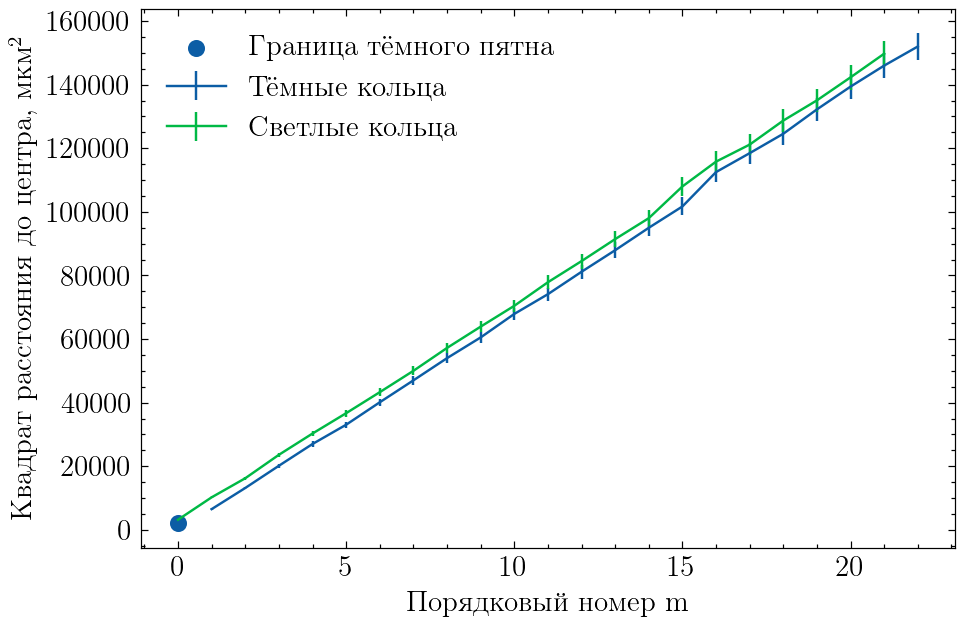

In [132]:
center_pos = 482 # +- 1
dark_dot = (482 - 435) * k[0]

dist = np.genfromtxt('iii-data.csv', skip_header=True) - center_pos
dist_si = (-dist)[::-1] * k[0]
dark_distances = dist_si[1::2]
light_distances = dist_si[::2]
m = np.arange(0, len(dist) / 2)

# dist_si**2 = (dist * k)**2
err = lambda dist : np.sqrt((k[0]**2 * 2*dist*1)**2 + (dist**2 * 2*k[0]*k[1])**2)
plt.errorbar(m+1, dark_distances**2, yerr=err(dark_distances), label='Тёмные кольца')
plt.errorbar(m, light_distances**2, yerr=err(light_distances), label='Светлые кольца')
plt.scatter(0, dark_dot**2, marker='o', label='Граница тёмного пятна')

plt.ylabel('Квадрат расстояния до центра, $\\text{мкм}^2$')
plt.xlabel('Порядковый номер m')
plt.legend()

plt.savefig(r'images/dark-light.svg')
plt.show()

**Тёмный проходит через (0,0)**

### Рассчёт кривизны

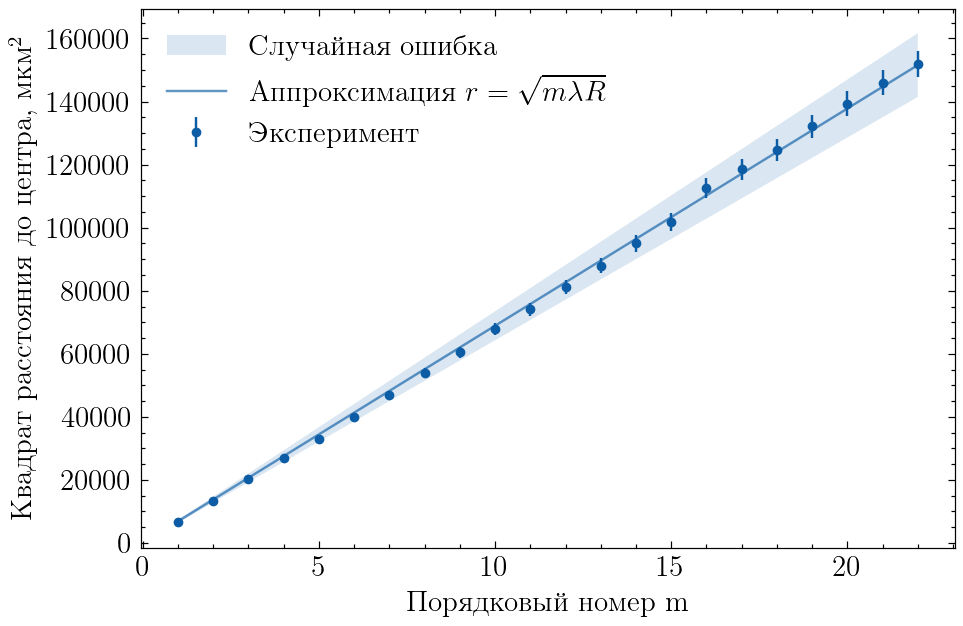

In [133]:
def line1(x, k):
    return k*x

([lR1], [[lR1_err]]) = curve_fit(line1, m+1, dark_distances**2)

plt.fill_between(m+1, line1(m+1, lR1+lR1_err), line1(m+1, lR1-lR1_err), alpha=.15, edgecolor='none', label='Случайная ошибка')
plt.plot(m+1, line1(m+1, lR1), alpha=.65, label=r'Аппроксимация $r=\sqrt{m\lambda R}$', color='C0')
plt.errorbar(m+1, dark_distances**2, yerr=err(dark_distances), label='Эксперимент', marker='.', linestyle='none', color='C0')

plt.ylabel('Квадрат расстояния до центра, $\\text{мкм}^2$')
plt.xlabel('Порядковый номер m')
plt.legend()

plt.savefig(r'images/dark-approx.svg')
plt.show()

In [134]:
R = lR1 / lamb
R_err = np.sqrt((1/lamb)**2 * lR1_err**2)
print(f'R = {R*1e-3:.3} +- {R_err*1e-3:.1} мм')

R = 11.9 +- 0.8 мм


## Обработка фото колец

### Расчёт кривизны

Импорт, кроп, удаление шумов медианным фильтром, перевод в чб фото

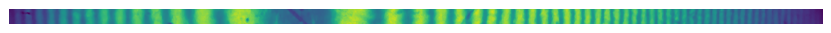

In [137]:
import imageio.v2 as im
from skimage.color import rgb2gray
from scipy import ndimage
from scipy.signal import find_peaks

face = im.imread('images/rings2.png')
face = face[170:2000,780:815]

face_intensity = np.fliplr(np.swapaxes(rgb2gray(face), 0, 1))
face_intensity = ndimage.median_filter(face_intensity, 4)

plt.imshow(face_intensity)
plt.axis('off')
plt.show()

Усреднение интенсивности пикселей по вертикали и поиск максимумов

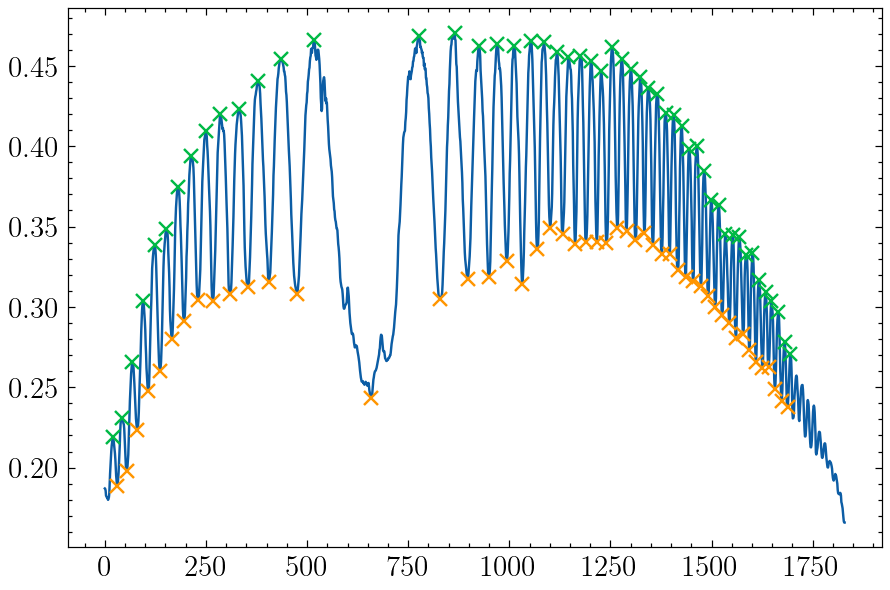

array([  20,   43,   68,   95,  123,  152,  182,  213,  250,  285,  332,
        379,  435,  516,  776,  865,  925,  970, 1012, 1054, 1085, 1118,
       1146, 1176, 1202, 1227, 1255, 1278, 1300, 1324, 1344, 1365, 1387,
       1406, 1426, 1445, 1464, 1482, 1499, 1518, 1534, 1552, 1569, 1586,
       1601, 1618, 1634, 1648, 1665, 1681, 1695])

In [138]:
intensity = np.mean(face_intensity, axis=0)

peaks, _ = find_peaks(intensity, distance=10, prominence=0.03)
lows, _ = find_peaks(-intensity, distance=10, prominence=0.03)

plt.plot(intensity)
plt.plot(peaks, intensity[peaks], "x")
plt.plot(lows, intensity[lows], "x")
plt.show()
peaks

Выбираем лучшую половину и нормируемся по центру **(между двумя светлыми участками)**

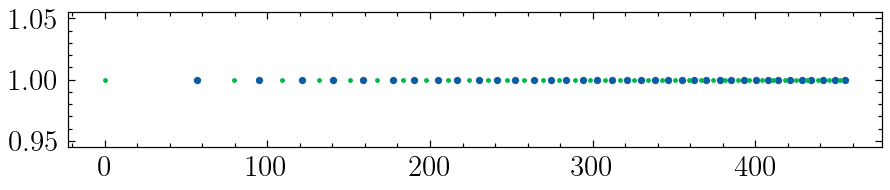

In [139]:
half_peaks = peaks[13:]
half_lows = lows[13:]
half_lows[0] = (half_peaks[1] + half_peaks[0]) / 2
half_peaks = half_peaks[1:]

# нормировка
real_dist = 2*(482-424)*k[0] # мкм
idx_dist = 786 - 526
step = real_dist / idx_dist
start = half_lows[0]
half_peaks = (half_peaks - start) * step
half_lows = (half_lows - start) * step

plt.figure(figsize=(6,1))
plt.scatter(half_peaks, np.ones(len(half_peaks)), s=4)
plt.scatter(half_lows, np.ones(len(half_lows)), s=1)
plt.show()

Квадрат расстояния в зависимости от пор. номера для светлых и тёмных

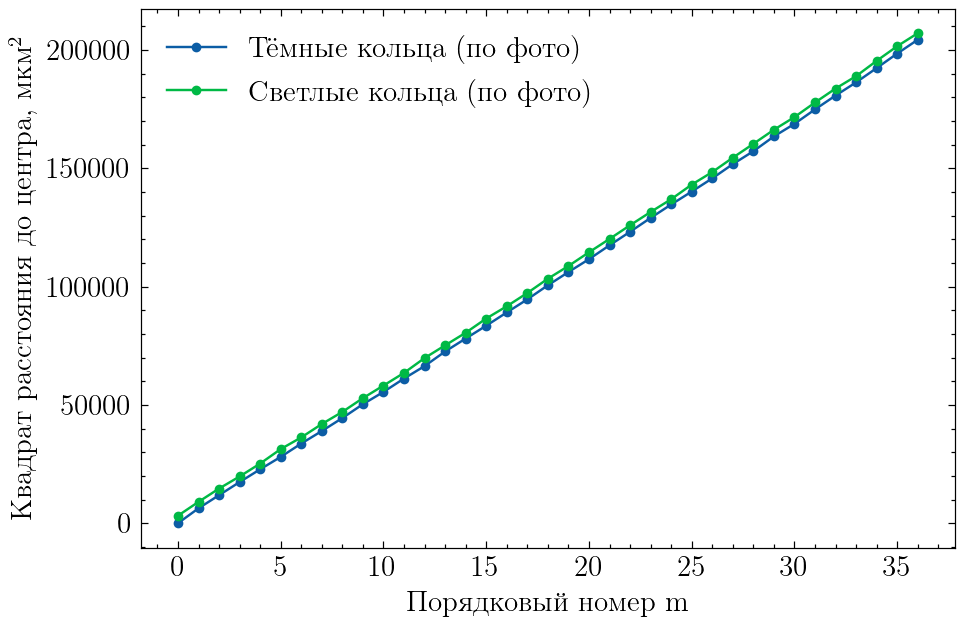

In [140]:
peaks_sqr = half_peaks**2
lows_sqr = half_lows**2
m_peaks = np.arange(0, len(half_peaks))
m_lows = np.arange(0, len(half_lows))

plt.plot(m_lows, lows_sqr, label='Тёмные кольца (по фото)', marker='.')
plt.plot(m_peaks, peaks_sqr, label='Светлые кольца (по фото)', marker='.')

plt.ylabel('Квадрат расстояния до центра, $\\text{мкм}^2$')
plt.xlabel('Порядковый номер m')
plt.legend()

plt.savefig(r'images/dark-light-from-photo.svg')
plt.show()

Аппроксимация прямой

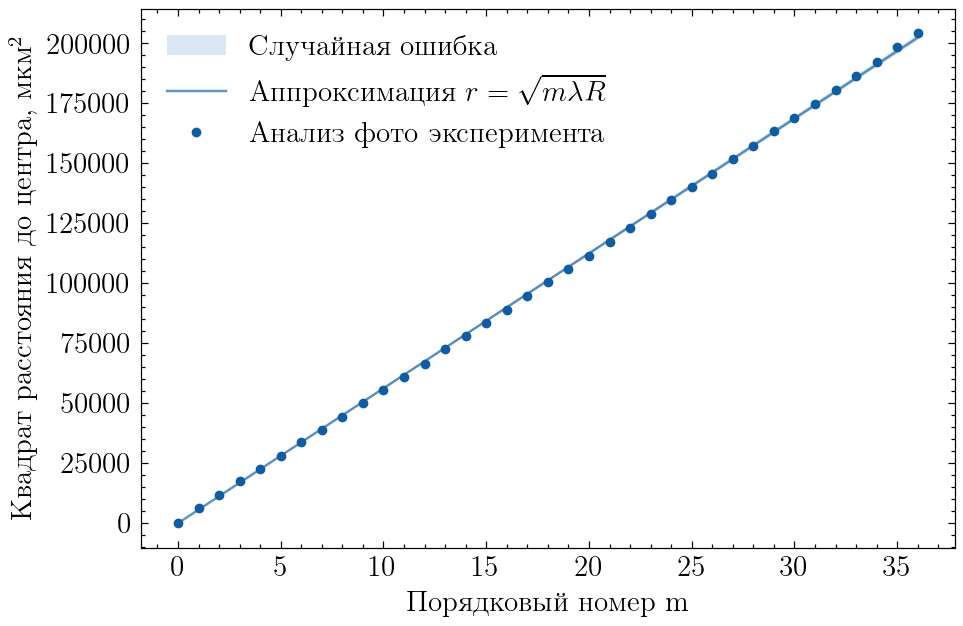

In [141]:
([lR1], [[lR1_err]]) = curve_fit(line1, m_lows, lows_sqr)

plt.fill_between(m_lows, line1(m_lows, lR1+lR1_err), line1(m_lows, lR1-lR1_err), alpha=.15, edgecolor='none', label='Случайная ошибка')
plt.plot(m_lows, line1(m_lows, lR1), alpha=.65, label=r'Аппроксимация $r=\sqrt{m\lambda R}$', color='C0')
plt.errorbar(m_lows, lows_sqr, label='Анализ фото эксперимента', marker='.', linestyle='none', color='C0')

plt.ylabel('Квадрат расстояния до центра, $\\text{мкм}^2$')
plt.xlabel('Порядковый номер m')
plt.legend()

plt.savefig(r'images/dark-approx-photo.svg')
plt.show()

Расчёт кривизны и погрешности

In [142]:
R = lR1 / lamb
R_err = np.sqrt((1/lamb)**2 * lR1_err**2)
print(f'R = {R*1e-3:.3} +- {R_err*1e-3:.1} мм')

R = 9.75 +- 0.06 мм


## Биения

In [143]:
face = im.imread('images/bieniya.png')
face = face[705:735,:]

face_intensity = rgb2gray(face)
face_intensity = ndimage.median_filter(face_intensity, 4)

plt.imshow(face_intensity)
plt.axis('off')
plt.show()

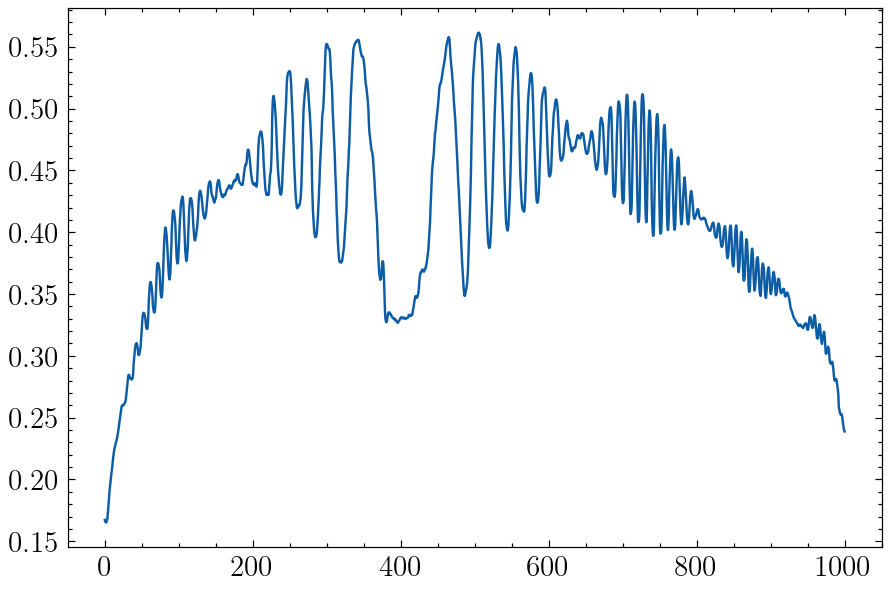

In [144]:
intensity = np.mean(face_intensity, axis=0)
x = np.linspace(0, 1000, len(intensity))
plt.plot(x, intensity)
plt.show()

### Разность длин волн, полученная при наблюдении биений

In [145]:
delta = 1/16 * lamb * 1e3 # нм
delta

36.0625

## Лабораторный журнал